In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA

from autoencoder import Autoencoder
from model_utils import load_model

In [2]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [3]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [47]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

# Epoch pairs: [(0, 1), (1, 2), ..., (epochs - 1, epochs)]
all_epoch_pairs = [(i, i + 1) for i in range(49)]

In [74]:
all_angles = []

for model in range(2):
    latent_matrices = []
    for epoch in range(3):
        latent_matrix = []
        model_path = os.getenv("HOME") + f'/sparsify_models/non_linear_models/{model}'
        sae = load_model(model_path, model_type="SAE", epoch=epoch)
        
        for image in test_images:
            image = torch.tensor(image, dtype=torch.float32).reshape(-1)

            with torch.no_grad():
                encoded, _ = sae(image)
                latent_matrix.append(encoded.detach().numpy())
        
        latent_matrix = np.stack(latent_matrix)

        pca = PCA(n_components=32)
        pca.fit(latent_matrix)

        latent_matrices.append(pca.components_)
    
    angles_per_model = []
    for i in range(32):
        angles_per_pc = []
        for j in range(2):
            cosine_angle = cosine_angle_between_pcs(latent_matrices[j][i], latent_matrices[j+1][i])
            angles_per_pc.append(cosine_angle)
        angles_per_model.append(angles_per_pc)
    all_angles.append(angles_per_model)

average_all_angles = np.mean(all_angles, axis=0)

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/mod

In [76]:
average_all_angles.shape

(32, 2)

In [66]:
latent_matrices[1][32]

IndexError: index 32 is out of bounds for axis 0 with size 32

In [48]:
# Dictionary to store the angle for each PC for each epoch pair
angle_dict = {}
for pc in range(32):
   if pc not in angle_dict:
       angle_dict[pc] = {}
   for epoch_pair in all_epoch_pairs:
       angle = cosine_angle_between_pcs(latent_matrices[epoch_pair[0]][pc], latent_matrices[epoch_pair[1]][pc])
       angle_dict[pc][epoch_pair] = angle

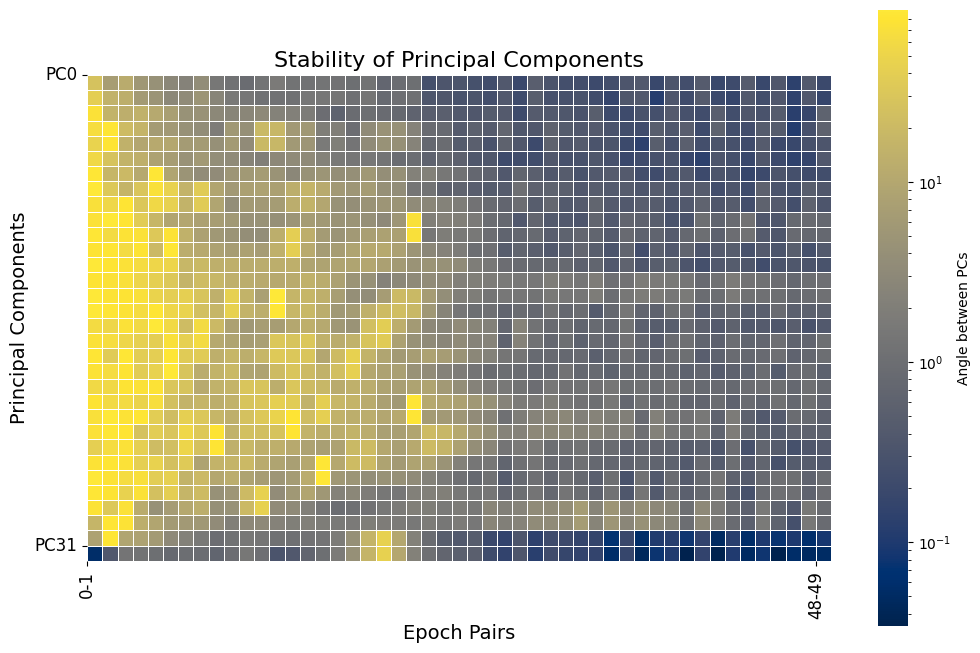

In [57]:
from matplotlib.colors import LogNorm

angle_matrix = np.zeros((len(angle_dict), len(all_epoch_pairs)))

# Fill matrix with angle data
for pc, epoch_data in angle_dict.items():
    i = 0
    for epoch_pair in all_epoch_pairs:
        angle_matrix[pc, i] = epoch_data[epoch_pair]
        i += 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    angle_matrix, 
    cmap="cividis",
    norm=LogNorm(), 
    xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
    yticklabels=[f"PC{pc}" for pc in angle_dict.keys()],
    cbar_kws={"label": "Angle between PCs"}, 
    linewidths=0.5,  # Subtle grid for readability
    square=True,  # Makes heatmap visually balanced
)
# Label only the first and last ticks
ax.set_xticks([0, len(all_epoch_pairs) - 1])
ax.set_xticklabels([f"{all_epoch_pairs[0][0]}-{all_epoch_pairs[0][1]}", 
                    f"{all_epoch_pairs[-1][0]}-{all_epoch_pairs[-1][1]}"], fontsize=12)

ax.set_yticks([0, len(angle_dict) - 1])
ax.set_yticklabels([f"PC{list(angle_dict.keys())[0]}", 
                    f"PC{list(angle_dict.keys())[-1]}"], fontsize=12)

# Improve labeling
ax.set_title("Stability of Principal Components", fontsize=16)
ax.set_xlabel("Epoch Pairs", fontsize=14)
ax.set_ylabel("Principal Components", fontsize=14)

plt.show()